In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

pd.set_option('display.max_colwidth', None)

In [2]:
sns.set(rc={'figure.figsize':(24,8.27)})

In [3]:
games = pd.read_csv('component_vaa_games_no_rushes.csv')
components = ['scramble','sack','incompletion','int','completed_air','completed_xyac','yacoe','completed_yac','completion','penalty']
display_components = ['scramble','sack','incompletion','int','completed_air','completed_xyac','yacoe','penalty']
display_component_renames = {'scramble':'Scramble VAA','sack':'Sack VAA','incompletion':'Incompletion VAA','int':'INT VAA','completed_air':'Completed Air Yard VAA','completed_xyac':'Expected YAC VAA','yacoe':'YAC over Expected VAA', 'penalty':'Penalty VAA'}

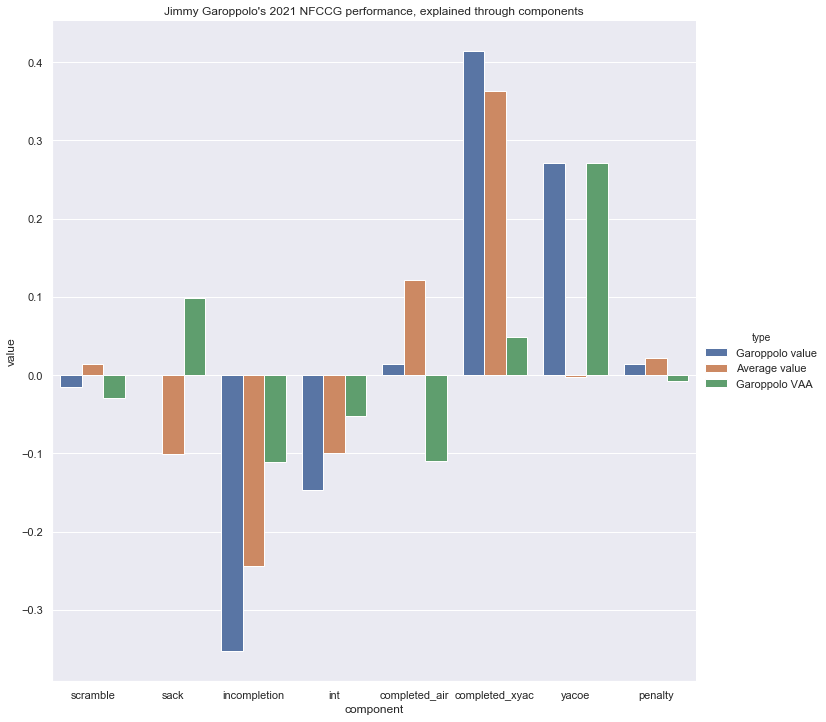

In [4]:
player_name = 'J.Garoppolo'
game_id = '2021_21_SF_LA'
eg_game = games.loc[(games.name==player_name)&(games.game_id==game_id)]
eg_dict = {f'{component}':{f'{player_name[2:]} value':eg_game[f'{component}_value'].iloc[0],
                            'Average value':games[f'{component}_value'].mean(),
                            f'{player_name[2:]} VAA':eg_game[f'{component}_vaa'].iloc[0]
                        } for component in display_components}
eg_df = pd.DataFrame(eg_dict).T.reset_index().rename(columns={'index':'component'})
eg_melt = pd.melt(eg_df, id_vars='component', var_name='type',value_name='value')
fig = sns.catplot(x='component',y='value',hue='type',kind='bar',data=eg_melt, height=10)
fig.set(title="Jimmy Garoppolo's 2021 NFCCG performance, explained through components")

Text(0.5, 1.0, 'Sack VAA comparison - Allen, Jackson, Mayfield, Darnold | 10 game rolling average | Dotted lines represent 25th, 50th, and 75th percentiles | @luckyprophet5')

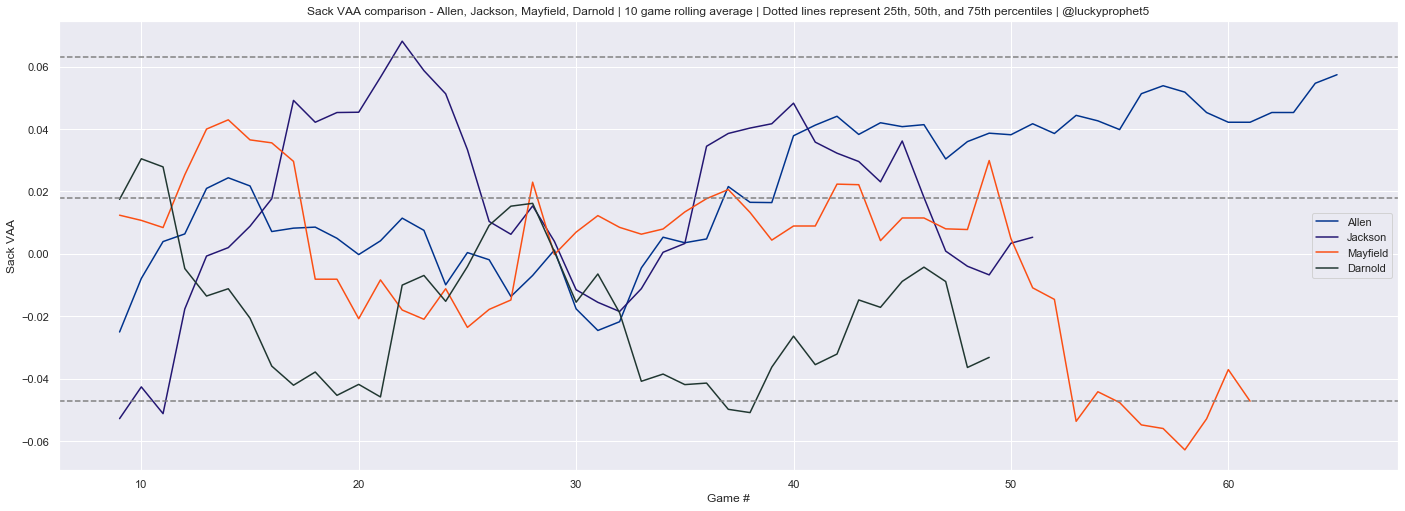

In [5]:
fig, ax = plt.subplots()

# https://gist.github.com/Deryck97/dff8d33e9f841568201a2a0d5519ac5e
COLORS = {'ARI':'#97233F','ATL':'#A71930','BAL':'#241773','BUF':'#00338D','CAR':'#0085CA','CHI':'#00143F',
          'CIN':'#FB4F14','CLE':'#FB4F14','DAL':'#93E9BE','DEN':'#002244','DET':'#046EB4','GB':'#24423C',
          'HOU':'#C9243F','IND':'#003D79','JAX':'#136677','KC':'#CA2430','LA':'#002147','LAC':'#2072BA',
          'LV':'#C4C9CC','MIA':'#0091A0','MIN':'#4F2E84','NE':'#0A2342','NO':'#A08A58','NYG':'#192E6C',
          'NYJ':'#203731','PHI':'#014A53','PIT':'#FFC20E','SEA':'#7AC142','SF':'#C9243F','TB':'#D40909',
          'TEN':'#4095D1','WAS':'#FFC20F'}

passers = {'J.Allen':'BUF','L.Jackson':'BAL','B.Mayfield':'CLE','S.Darnold':'NYJ'}
component = 'sack'

for passer,team in passers.items():
   sns.lineplot(data=games.loc[(games['name']==passer)].reset_index().rolling(10).mean()[f'{component}_vaa'], ax=ax, color=COLORS[team])
# sns.lineplot(data=games.loc[games['name']=='D.Brees'].reset_index().rolling(10).mean()[f'{component}_vaa'], ax=ax, color=COLORS['NO'])
ax.axhline(games[f'{component}_vaa'].quantile(.25), color='gray', linestyle='--')
ax.axhline(games[f'{component}_vaa'].quantile(.5), color='gray', linestyle='--')
ax.axhline(games[f'{component}_vaa'].quantile(.75), color='gray', linestyle='--')
names = [name[2:] for name in passers.keys()]
ax.legend(names)
ax.set_xlabel("Game #")
ax.set_ylabel(f"{component.title()} VAA")
ax.set_title(f"{component.title()} VAA comparison - {', '.join(names)} | 10 game rolling average | Dotted lines represent 25th, 50th, and 75th percentiles | @luckyprophet5")

In [6]:
seasons = games.loc[games.season_type=='REG'].groupby(['season','posteam','name'])\
    .agg({**{f'weighted_{component}_value':'sum' for component in components},
         **{f'weighted_{component}_vaa':'sum' for component in components},
          'play_id':'sum', 'weighted_epa':'sum'})\
    .query('play_id>300')
seasons['play_id'] = seasons['play_id'].astype(int)
seasons['epa'] = seasons['weighted_epa']/seasons['play_id']

def ordinal_fn(n):
    if n%100 in [11,12,13]:
        return 'th'
    ordinal_mapping = {0:'th',1:'st',2:'nd',3:'rd',**{num:'th' for num in range(4,10)}}
    return ordinal_mapping[n%10]

for component in components:
    seasons[f'{component}_value'] = seasons[f'weighted_{component}_value']/seasons['play_id']
    seasons[f'{component}_vaa'] = seasons[f'weighted_{component}_vaa']/seasons['play_id']
    seasons[f'{component}_pctile'] = (seasons[f'{component}_vaa'].rank(pct=True).round(2)*100).astype(int)
    ordinal = seasons[f'{component}_pctile'].apply(ordinal_fn)
    seasons[f'{component}_VAA'] = seasons[f'{component}_vaa'].round(3).astype(str) + ' (' + seasons[f'{component}_pctile'].astype(str) + ordinal + ')'
seasons['epa_pctile'] = (seasons['epa'].rank(pct=True).round(2)*100).astype(int)
seasons['EPA/play'] = seasons[f'epa'].round(3).astype(str) + ' (' + seasons[f'epa_pctile'].astype(str) + seasons[f'epa_pctile'].apply(ordinal_fn) + ')'
seasons.reset_index(inplace=True)

season = 2021

# to map the vaa (float cols) colors to the VAA (string cols) background 
gmap = seasons.loc[seasons.season==season][[f'{component}_vaa' for component in display_components]+['epa']]\
    .sort_values('epa',ascending=False)\
    .set_index(np.arange(1, 32))\
    .rename(columns={**{f'{key}_vaa':val for key,val in display_component_renames.items()},'epa':'EPA/play'})
# rescale epa so it doesn't break the background gradient (doesn't change the displayed epa values) 
gmap['EPA/play'] = gmap['EPA/play'] - gmap['EPA/play'].mean() 

seasons.loc[seasons.season==season][['posteam','name']+[f'{component}_VAA' for component in display_components]+['EPA/play','epa','play_id']]\
    .sort_values('epa',ascending=False)\
    .set_index(np.arange(1, 32))\
    .drop(columns=['epa'])\
    .rename(columns={'posteam':'Team','name':'Name','play_id':'# plays', **{f'{key}_VAA':val for key,val in display_component_renames.items()}})\
    .style.set_caption("2021 QBs | min 300 plays | Parentheses include percentiles among all QB seasons since 2006 | VAA = Value Above Average | @luckyprophet5").background_gradient(axis=None,gmap=gmap, subset=list(display_component_renames.values())+['EPA/play'],cmap=cm.get_cmap('bwr').reversed())

,Team,Name,Scramble VAA,Sack VAA,Incompletion VAA,INT VAA,Completed Air Yard VAA,Expected YAC VAA,YAC over Expected VAA,Penalty VAA,EPA/play,# plays
1,GB,A.Rodgers,0.0 (61st),0.022 (74th),0.02 (70th),0.06 (96th),-0.061 (20th),0.105 (99th),0.012 (70th),0.01 (76th),0.255 (92nd),606
2,KC,P.Mahomes,0.022 (91st),0.04 (89th),0.051 (96th),0.019 (67th),-0.102 (8th),0.073 (95th),0.047 (91st),-0.005 (40th),0.23 (88th),784
3,TB,T.Brady,-0.008 (37th),0.046 (93rd),0.008 (54th),0.031 (79th),-0.039 (31st),0.093 (98th),-0.005 (49th),-0.004 (42nd),0.209 (85th),779
4,LA,M.Stafford,-0.008 (40th),0.009 (57th),-0.001 (43rd),-0.009 (36th),0.086 (88th),0.051 (86th),-0.016 (35th),-0.003 (44th),0.2 (83rd),670
5,SF,J.Garoppolo,-0.023 (1st),-0.003 (44th),0.042 (92nd),-0.008 (38th),0.016 (56th),0.021 (69th),0.067 (97th),-0.0 (55th),0.197 (82nd),497
6,LAC,J.Herbert,0.011 (80th),0.031 (84th),0.008 (55th),0.002 (50th),-0.019 (39th),0.05 (86th),0.022 (79th),-0.006 (36th),0.193 (81st),791
7,CIN,J.Burrow,0.0 (60th),-0.047 (8th),0.068 (100th),-0.022 (26th),-0.013 (42nd),0.051 (87th),0.069 (97th),-0.004 (41st),0.19 (80th),626
8,BUF,J.Allen,0.043 (98th),0.053 (97th),-0.002 (42nd),0.011 (61st),0.031 (65th),-0.008 (47th),-0.032 (19th),-0.01 (26th),0.173 (74th),761
9,DAL,D.Prescott,-0.011 (27th),0.023 (76th),0.028 (79th),0.035 (81st),-0.005 (45th),0.039 (81st),-0.017 (33rd),-0.014 (16th),0.165 (72nd),700
10,ARI,K.Murray,0.006 (72nd),0.011 (60th),0.021 (71st),-0.0 (47th),0.001 (49th),0.055 (88th),-0.024 (27th),-0.001 (54th),0.153 (70th),573


In [7]:
# compare completed air, xyac, yacoe, and yac columns
comparison_components = ['completed_air','completed_xyac','yacoe','completion']
gmap = seasons.loc[seasons.season==season][[f'{component}_vaa' for component in comparison_components]+['epa']]\
    .sort_values('epa',ascending=False)\
    .set_index(np.arange(1, 32))\
    .rename(columns={**{f'{component}_vaa':f'{component}_VAA' for component in comparison_components},'epa':'EPA/play'})
# rescale epa so it doesn't break the background gradient (doesn't change the displayed epa values) 
gmap['EPA/play'] = gmap['EPA/play'] - gmap['EPA/play'].mean() 

seasons.loc[seasons.season==season][['posteam','name']+[f'{component}_VAA' for component in comparison_components]+['EPA/play','epa','play_id']]\
    .sort_values('epa',ascending=False)\
    .set_index(np.arange(1, 32))\
    .drop(columns=['epa'])\
    .rename(columns={'posteam':'Team','name':'Name','play_id':'# plays'})\
    .style.set_caption("2021 QBs | min 300 plays | Parentheses include percentiles among all QB seasons since 2006 | VAA = Value Above Average | @luckyprophet5").background_gradient(axis=None,gmap=gmap, subset=[f'{component}_VAA' for component in comparison_components]+['EPA/play'],cmap=cm.get_cmap('bwr').reversed())

,Team,Name,completed_air_VAA,completed_xyac_VAA,yacoe_VAA,completion_VAA,EPA/play,# plays
1,GB,A.Rodgers,-0.061 (20th),0.105 (99th),0.012 (70th),0.073 (83rd),0.255 (92nd),606
2,KC,P.Mahomes,-0.102 (8th),0.073 (95th),0.047 (91st),0.017 (63rd),0.23 (88th),784
3,TB,T.Brady,-0.039 (31st),0.093 (98th),-0.005 (49th),0.055 (79th),0.209 (85th),779
4,LA,M.Stafford,0.086 (88th),0.051 (86th),-0.016 (35th),0.138 (96th),0.2 (83rd),670
5,SF,J.Garoppolo,0.016 (56th),0.021 (69th),0.067 (97th),0.089 (89th),0.197 (82nd),497
6,LAC,J.Herbert,-0.019 (39th),0.05 (86th),0.022 (79th),0.051 (77th),0.193 (81st),791
7,CIN,J.Burrow,-0.013 (42nd),0.051 (87th),0.069 (97th),0.105 (92nd),0.19 (80th),626
8,BUF,J.Allen,0.031 (65th),-0.008 (47th),-0.032 (19th),0.002 (54th),0.173 (74th),761
9,DAL,D.Prescott,-0.005 (45th),0.039 (81st),-0.017 (33rd),0.034 (68th),0.165 (72nd),700
10,ARI,K.Murray,0.001 (49th),0.055 (88th),-0.024 (27th),0.04 (72nd),0.153 (70th),573


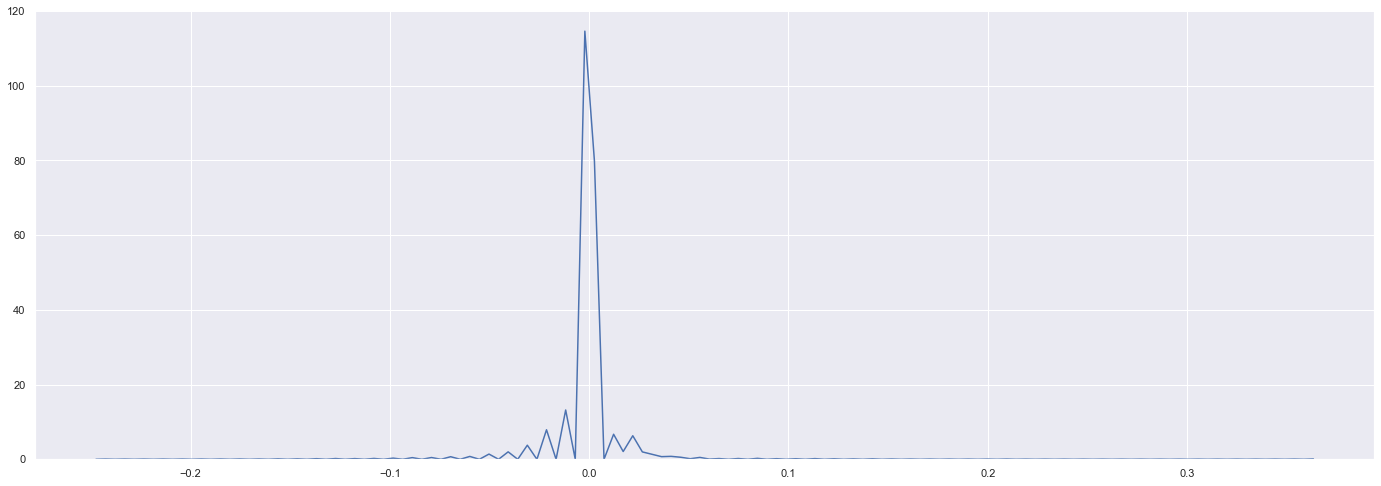

In [8]:
# check that components more or less add up to a QB's EPA
sns.kdeplot(games[[f'{component}_value' for component in display_components]].sum(axis=1) - games['epa'])

In [9]:
# I stole this code from @EthanCDouglas and modified it a bit
def year_to_year_corr(columns, groupby, data):
    cols = [groupby, 'season'] + columns 
    data = data[cols]
    ldata = data.groupby(by=groupby).shift(-1)
    data.columns = [groupby, 'prev_season'] + [f'prev_{col}' for col in columns]
    new_data = pd.concat((data, ldata), axis=1).dropna(subset=['season']).drop(columns=['prev_season','season'])
    tot_corr = new_data.corr(method='pearson')
    num_corr_cols = len(columns)-1 # minus one bc 'posteam' shouldn't count 
    corr = tot_corr.iloc[num_corr_cols:,num_corr_cols:]
    pred = tot_corr.iloc[0:num_corr_cols, num_corr_cols:]
    return new_data,corr,pred

yoy, corr, pred = year_to_year_corr([f'{component}_vaa' for component in components] + ['posteam','epa'], 'name', seasons)
corr[['epa']].sort_values('epa',ascending=False).style.background_gradient()

,epa
epa,1.000000
completion_vaa,0.856363
incompletion_vaa,0.590932
completed_yac_vaa,0.512938
int_vaa,0.507172
yacoe_vaa,0.495644
completed_air_vaa,0.465356
sack_vaa,0.429775
completed_xyac_vaa,0.283798
penalty_vaa,0.194259


In [10]:
print("year over year stability, all QB seasons (min 300 plays):")
pred.style.background_gradient(axis=None)

year over year stability, all QB seasons (min 300 plays):


,scramble_vaa,sack_vaa,incompletion_vaa,int_vaa,completed_air_vaa,completed_xyac_vaa,yacoe_vaa,completed_yac_vaa,completion_vaa,penalty_vaa,epa
prev_scramble_vaa,0.529358,-0.153251,0.115318,0.188068,-0.009453,-0.234895,0.015050,-0.158178,-0.135408,-0.008734,0.016255
prev_sack_vaa,-0.237798,0.352165,-0.008568,-0.059053,-0.019231,0.192129,0.028559,0.164924,0.113755,-0.006508,0.114261
prev_incompletion_vaa,0.068840,0.112201,0.460781,0.159350,0.041052,0.278335,0.163409,0.307338,0.283065,0.017882,0.384520
prev_int_vaa,0.180617,0.007574,0.191052,0.287515,-0.064019,0.120004,0.025097,0.110411,0.025737,0.092859,0.184940
prev_completed_air_vaa,-0.102311,0.093510,0.020380,-0.163530,0.396488,-0.231928,0.085617,-0.122140,0.286447,0.023652,0.151853
prev_completed_xyac_vaa,-0.212703,0.240874,0.238336,0.144403,-0.205533,0.573287,-0.020661,0.414325,0.131015,0.049308,0.234905
prev_yacoe_vaa,0.029905,0.111924,0.067439,0.148734,0.027089,-0.026600,0.322705,0.188345,0.175071,-0.003834,0.196099
prev_completed_yac_vaa,-0.123215,0.231716,0.205524,0.216095,-0.149919,0.403059,0.188959,0.424418,0.192078,0.028922,0.285035
prev_completion_vaa,-0.197265,0.274625,0.185139,0.017398,0.257247,0.102912,0.233257,0.224527,0.427115,0.044399,0.373271
prev_penalty_vaa,0.007522,0.014296,-0.026404,0.094551,-0.002445,0.099854,-0.109568,0.021645,0.013807,0.239968,0.061272


In [11]:
print("year over year stability, QBs who changed teams (min 300 plays):")
switch_yoy = yoy.loc[yoy.posteam!=yoy.prev_posteam]
switch_pred = switch_yoy.corr().iloc[0:11, 11:]
switch_pred.style.background_gradient(axis=None)

year over year stability, QBs who changed teams (min 300 plays):


,scramble_vaa,sack_vaa,incompletion_vaa,int_vaa,completed_air_vaa,completed_xyac_vaa,yacoe_vaa,completed_yac_vaa,completion_vaa,penalty_vaa,epa
prev_scramble_vaa,0.469817,-0.047764,0.169693,0.297302,-0.051490,-0.099543,0.130768,-0.028700,-0.078593,-0.119532,0.147133
prev_sack_vaa,-0.402413,0.300130,-0.154912,-0.216695,0.011944,0.069955,-0.279485,-0.100531,-0.066914,-0.014849,-0.148908
prev_incompletion_vaa,0.083196,0.118109,0.358331,0.071906,-0.169457,0.177791,0.218034,0.299292,0.061041,-0.098386,0.200748
prev_int_vaa,0.164644,-0.005875,0.019362,0.274546,-0.199736,0.106957,-0.137181,-0.000067,-0.213363,-0.052915,-0.039118
prev_completed_air_vaa,-0.113174,0.123782,-0.068859,-0.212972,0.302460,-0.192694,0.165435,-0.068377,0.265548,-0.103934,0.115571
prev_completed_xyac_vaa,-0.207900,0.271935,0.207052,0.079261,-0.192918,0.464296,-0.197568,0.268373,0.012288,0.191027,0.148064
prev_yacoe_vaa,0.123798,-0.059334,-0.043218,0.054155,0.021190,-0.198693,0.069008,-0.076454,-0.037327,-0.143649,-0.062638
prev_completed_yac_vaa,-0.092842,0.144134,0.142231,0.102642,-0.138777,0.225632,-0.081056,0.168260,-0.010764,0.006477,0.070154
prev_completion_vaa,-0.246162,0.310990,0.085577,-0.143442,0.203811,0.028724,0.112925,0.115900,0.310424,-0.121932,0.220512
prev_penalty_vaa,-0.123935,-0.026018,0.012256,0.143893,0.017599,0.285864,-0.274342,0.081091,0.083150,0.355833,0.112405


In [12]:
seasons_split = games.loc[(games.season_type=='REG')&(games.week<=8)].groupby(['season','posteam','name'])\
    .agg({**{f'weighted_{component}_value':'sum' for component in components},
         **{f'weighted_{component}_vaa':'sum' for component in components},
          'play_id':'sum', 'weighted_epa':'sum'})\
    .query('play_id>100')
seasons_split['play_count_1H'] = seasons_split['play_id'].astype(int)
seasons_split['epa_1H'] = seasons_split['weighted_epa']/seasons_split['play_id']
for component in components:
    seasons_split[f'{component}_vaa_1H'] = seasons_split[f'weighted_{component}_vaa']/seasons_split['play_count_1H']
seasons_split = seasons_split\
    .drop(columns=[f'weighted_{component}_value' for component in components]
    +[f'weighted_{component}_vaa' for component in components]
    +['play_id','weighted_epa'])
    
seasons_split = pd.concat([seasons_split,games.loc[(games.season_type=='REG')&(games.week>8)].groupby(['season','posteam','name'])\
    .agg({**{f'weighted_{component}_value':'sum' for component in components},
         **{f'weighted_{component}_vaa':'sum' for component in components},
          'play_id':'sum', 'weighted_epa':'sum'})\
    .query('play_id>100')], axis=1)

seasons_split.dropna(inplace=True)

seasons_split['play_count_2H'] = seasons_split['play_id'].astype(int)
seasons_split['epa_2H'] = seasons_split['weighted_epa']/seasons_split['play_id']
for component in components:
    seasons_split[f'{component}_vaa_2H'] = seasons_split[f'weighted_{component}_vaa']/seasons_split['play_count_2H']
seasons_split = seasons_split\
    .drop(columns=[f'weighted_{component}_value' for component in components]
    +[f'weighted_{component}_vaa' for component in components]
    +['play_id','weighted_epa'])\
    .reset_index()
cols = [f'{component}_vaa' for component in components]+['epa']
split_season_corr = seasons_split.corr()

In [13]:
def display_table_str(s):
    return s.replace('_',' ').title().replace('Vaa','VAA').replace('Yac','YAC').replace('yac','YAC').replace('Epa','EPA')

pd.DataFrame({
    'Year to Year R² (all QBs)':{display_table_str(col):(pred.loc[f'prev_{col}',col]**2) for col in cols}, 
    'Year to Year R² (switching teams)':{display_table_str(col):switch_pred.loc[f'prev_{col}',col]**2 for col in cols},
    'R² with next year\'s EPA (all QBs)': {display_table_str(col):pred.loc[f'prev_{col}','epa']**2 for col in cols},
    'R² with next year\'s EPA (switching teams)':{display_table_str(col):switch_pred.loc[f'prev_{col}','epa']**2 for col in cols},
    'R²: weeks 1-8 and weeks 8+':{display_table_str(col):split_season_corr.loc[f'{col}_1H',f'{col}_2H']**2 for col in cols}, 
    'R²: weeks 1-8 and EPA from weeks 8+': {display_table_str(col):split_season_corr.loc[f'{col}_1H',f'epa_2H']**2 for col in cols},
}).style.background_gradient(axis=0)

,Year to Year R² (all QBs),Year to Year R² (switching teams),R² with next year's EPA (all QBs),R² with next year's EPA (switching teams),R²: weeks 1-8 and weeks 8+,R²: weeks 1-8 and EPA from weeks 8+
Scramble VAA,0.280219,0.220728,0.000264,0.021648,0.121585,0.013742
Sack VAA,0.124020,0.090078,0.013055,0.022174,0.092698,0.053488
Incompletion VAA,0.212319,0.128401,0.147855,0.040300,0.071264,0.112033
Int VAA,0.082665,0.075376,0.034203,0.001530,0.042383,0.051712
Completed Air VAA,0.157203,0.091482,0.023059,0.013357,0.280613,0.075655
Completed XYAC VAA,0.328658,0.215570,0.055181,0.021923,0.338038,0.034887
YACoe VAA,0.104138,0.004762,0.038455,0.003924,0.083825,0.032880
Completed YAC VAA,0.180131,0.028311,0.081245,0.004922,0.216931,0.062869
Completion VAA,0.182427,0.096363,0.139331,0.048626,0.250285,0.210185
Penalty VAA,0.057585,0.126617,0.003754,0.012635,0.023856,0.001604


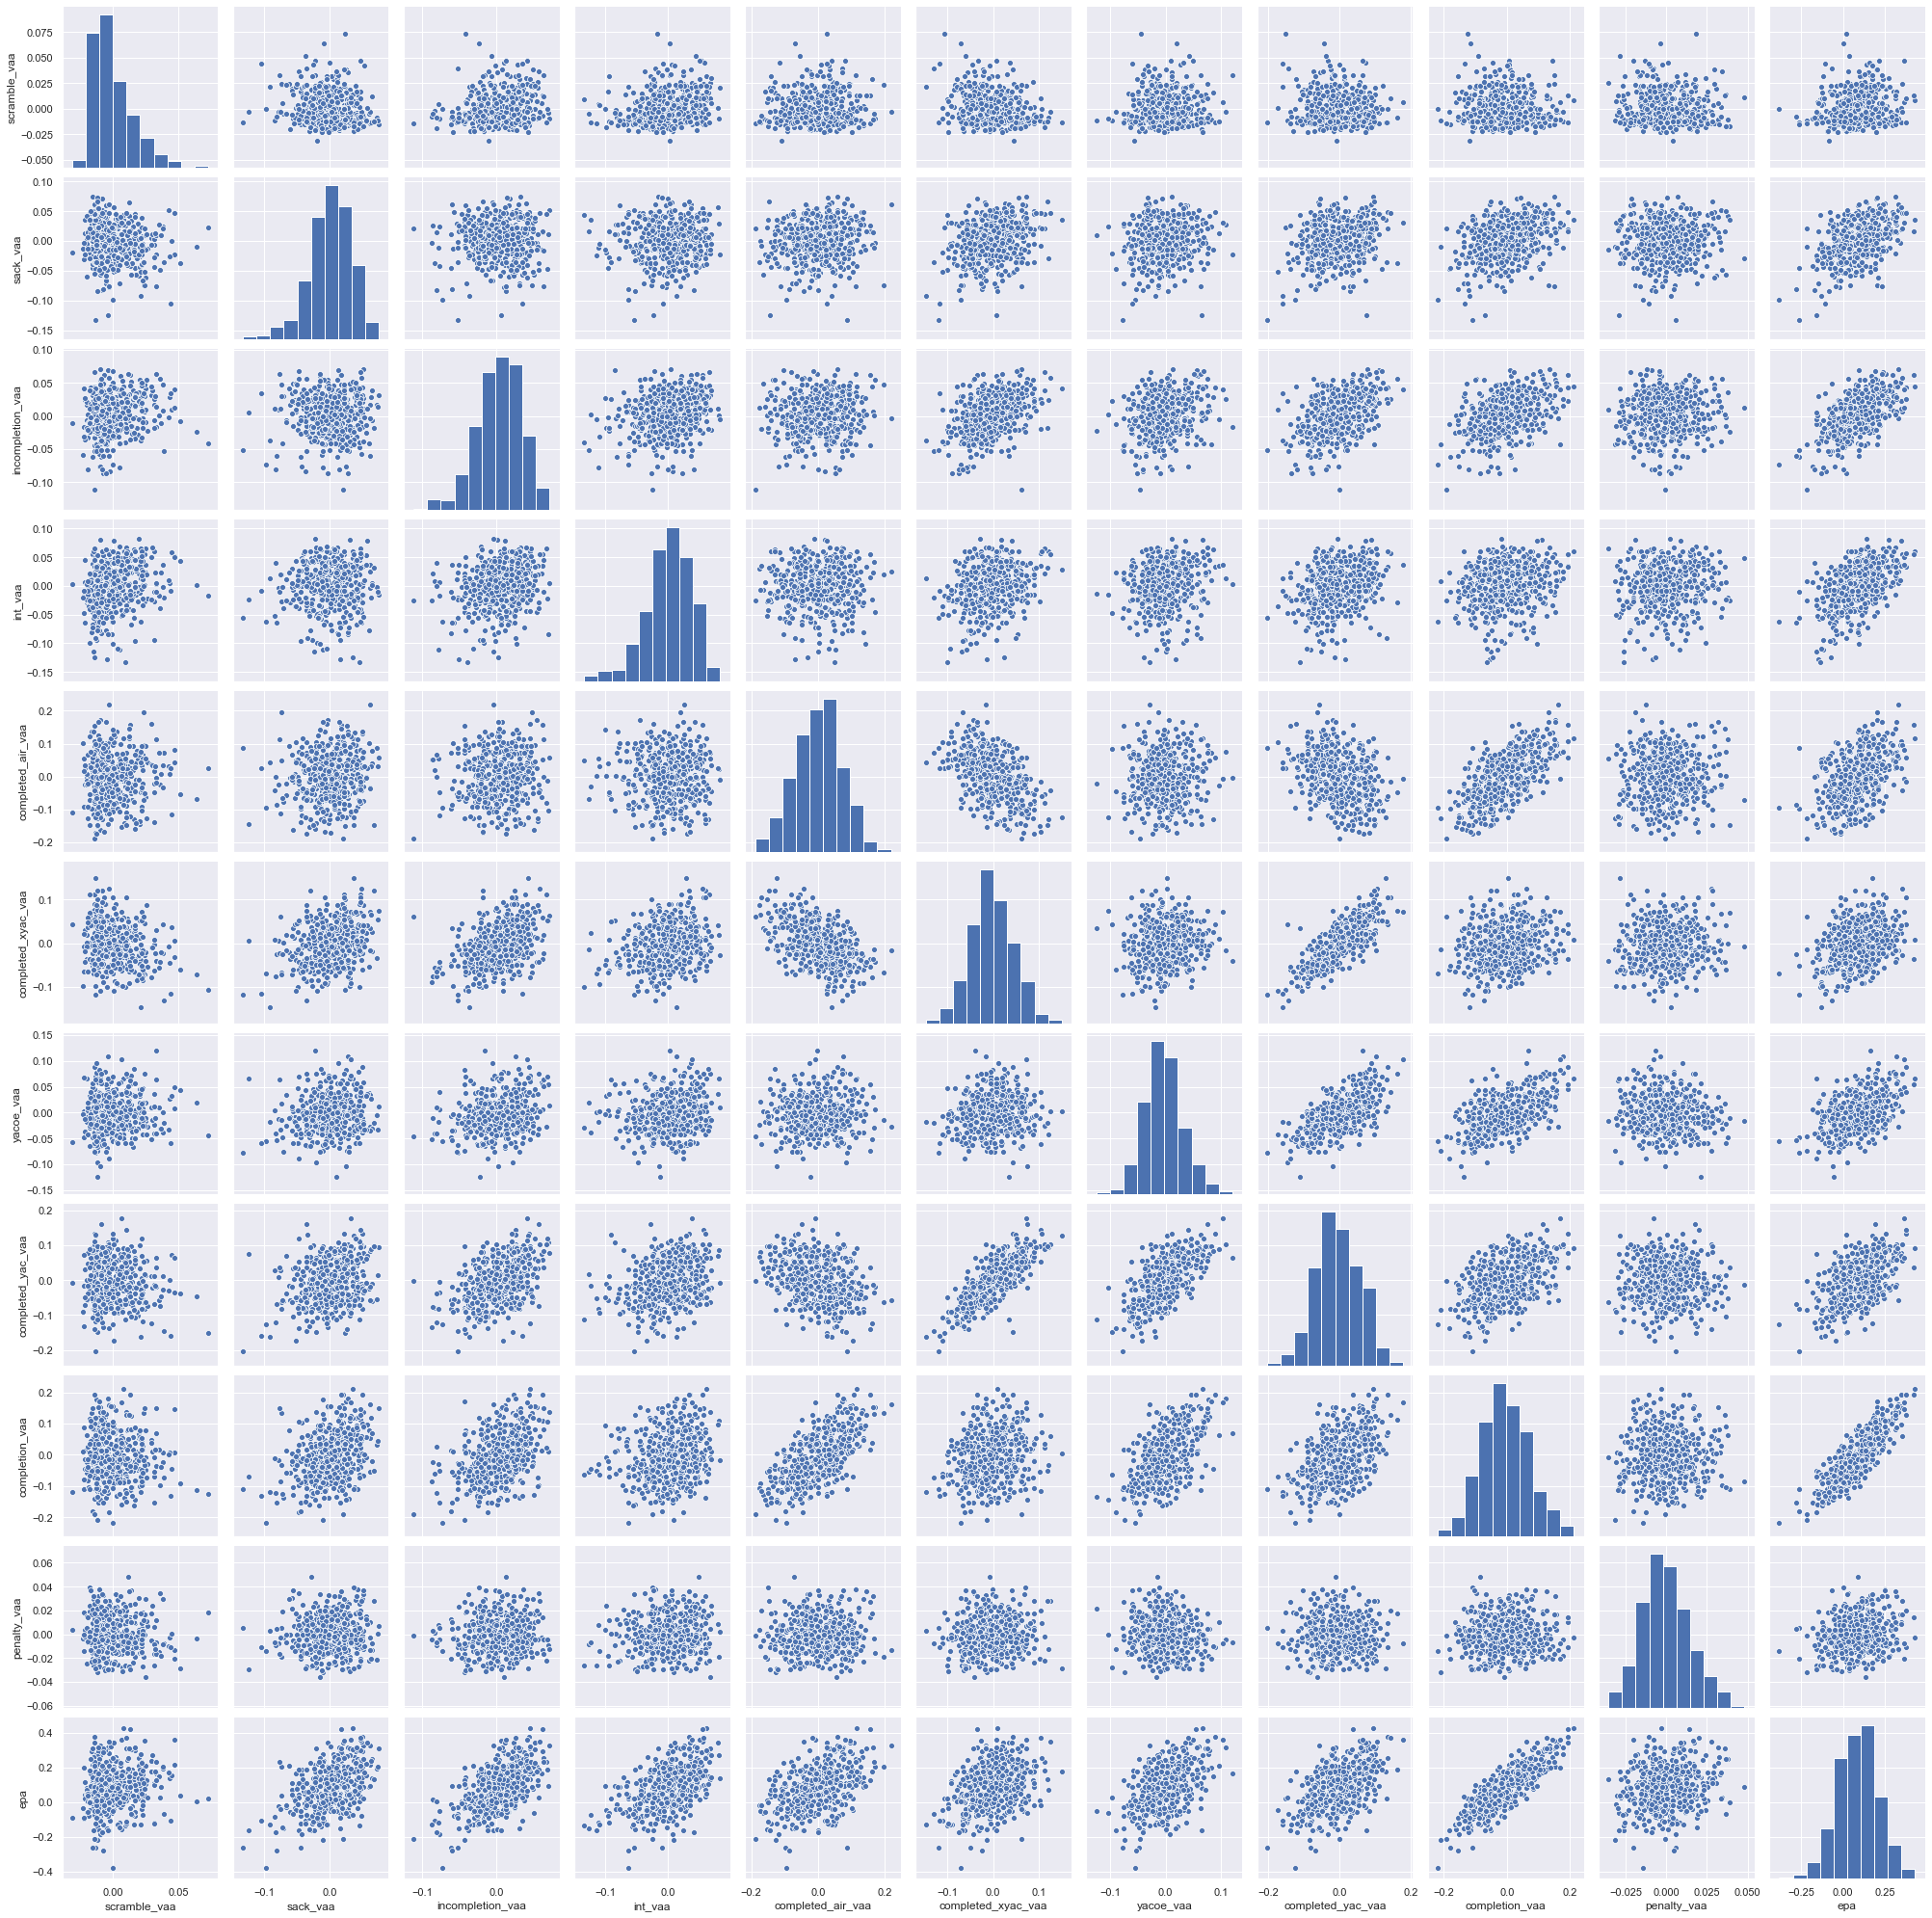

In [15]:
sns.pairplot(seasons[[f'{component}_vaa' for component in components]+['epa']])